In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import pdb
%matplotlib inline

tfe.enable_eager_execution()

In [2]:
mnist = input_data.read_data_sets('../datasets/MNIST_data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../datasets/MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../datasets/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ../datasets/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ../datasets/MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


(55000, 784)

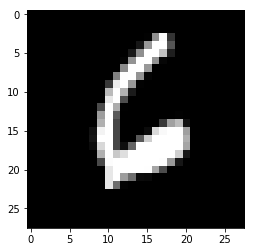

In [3]:
plt.rcParams['image.cmap'] = 'gray'
sample_img = mnist.train.images[3]
plt.imshow(sample_img.reshape([28, 28]))
mnist.train.images.shape

In [60]:
class RBM:
    def __init__(self, visible_dim, hidden_dim):
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        
        # initiating weight variables
        self.W = tf.Variable(np.random.normal(loc=0., scale=0.1, size=(visible_dim, hidden_dim)), dtype=tf.float32)
        self.c = tf.Variable(np.ones((visible_dim, 1)), dtype=tf.float32)
        self.b = tf.Variable(np.ones((hidden_dim, 1)), dtype=tf.float32)
    
    
    def _energy(self, x, h):
        e = tf.matmul(tf.matmul(x, self.W), tf.transpose(h))
        e = tf.diag_part(e) + tf.matmul(x, self.c) + tf.matmul(h, self.b)
        e = e / tf.cast(tf.shape(x)[0], dtype=tf.float32)
        return -1 * e
    
    
    def _prob_of_h_given_x(self, x):
        """
        Input shape
            x:  N * V
        """
        
        tensor_x = tf.convert_to_tensor(x, dtype=tf.float32)
        return tf.sigmoid(tf.matmul(tensor_x, self.W) + tf.transpose(self.b))  
    
    
    def _prob_of_x_given_h(self, h):
        """
        Input shape
            h:  N * H
        """
        
        tensor_h = tf.convert_to_tensor(h, dtype=tf.float32)
        return tf.sigmoid(tf.matmul(tensor_h, tf.transpose(self.W)) + tf.transpose(self.c))    
    
    
    def _sample_from_dist(self, dist):
        sample = tf.random.uniform(minval=0, maxval=1, shape=dist.shape)
        return tf.cast((dist > sample), dtype=tf.float32)
    
    
    def gibbs_sampler(self, x, k=1, sample=True, return_prob=False):
        x_tilde = x
        
        for _ in range(k):
            h_dist = self._prob_of_h_given_x(x_tilde)
            if sample:
                h = self._sample_from_dist(h_dist)
            else:
                h = h_dist
            
            x_dist = self._prob_of_x_given_h(h)
            if sample:
                x_tilde = self._sample_from_dist(x_dist)
            else:
                x_tilde = x_dist
        
        if return_prob:
            return x_dist
        else:
            return self._sample_from_dist(x_dist)
    
    
    def update_weights(self, x, learning_rate=0.005, **kargs):
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        batch_size = tf.cast(tf.shape(x)[0], dtype=tf.float32)
        
        x_tilde = self.gibbs_sampler(x, **kargs)
        h_tilde_of_x = self._prob_of_h_given_x(x)
        h_tilde_of_x_tilde = self._prob_of_h_given_x(x_tilde)
        
        with tf.GradientTape(persistent=True) as tape:
            possitive_energy = self._energy(x, h_tilde_of_x)
            negative_energy = self._energy(x_tilde, h_tilde_of_x_tilde)
        
        grad_W = (tape.gradient(possitive_energy, self.W) - tape.gradient(negative_energy, self.W)) / batch_size
        grad_b = (tape.gradient(possitive_energy, self.b) - tape.gradient(negative_energy, self.b)) / batch_size
        grad_c = (tape.gradient(possitive_energy, self.c) - tape.gradient(negative_energy, self.c)) / batch_size
          
#         grad_E_h_tilde_given_x = tf.matmul(tf.transpose(x), h_tilde_of_x)
#         grad_E_h_tilde_given_x_tilde = tf.matmul(tf.transpose(x), h_tilde_of_x_tilde)
        
#         grad_W_v2 = -1 * (grad_E_h_tilde_given_x - grad_E_h_tilde_given_x_tilde) / batch_size
#         grad_b_v2 = -1 * tf.reduce_sum((h_tilde_of_x - h_tilde_of_x_tilde), axis=0) / batch_size
#         grad_c_v2 = -1 * tf.reduce_sum((x - x_tilde), axis=0) / batch_size   
        
#         print(1)
#         assert abs(np.mean(grad_W) - np.mean(grad_W_v2)) < 0.001, f"W gradient difference: {(np.mean(grad_W) - np.mean(grad_W_v2))}"
#         assert abs(np.mean(grad_b) - np.mean(grad_b_v2)) < 0.001, f"b gradient difference: {(np.mean(grad_b) - np.mean(grad_b_v2))}"
#         assert abs(np.mean(grad_c) - np.mean(grad_c_v2)) < 0.001, f"c gradient difference: {(np.mean(grad_c) - np.mean(grad_c_v2))}"
        
        self.W.assign_sub(learning_rate * grad_W)
        self.c.assign_sub(learning_rate * grad_c)
        self.b.assign_sub(learning_rate * grad_b) 
#         pdb.set_trace()

In [89]:
def get_loss(y, output):
    loss = -1. * ((y * tf.log(output)) + ((1. - y) * (tf.log(1. - output))))
#     l1 = tf.reduce_mean(loss)
#     l2 = tf.reduce_sum(loss) / tf.cast(tf.shape(y)[0], dtype=tf.float32)
#     pdb.set_trace()
    return tf.reduce_mean(loss)


epoch = 30
batch_size = 500
accuracy_size = 500
max_iter = int(mnist.train.num_examples/batch_size)
print_every = 100

rbm = RBM(784, 200)

for e in range(epoch):
    for it in range(max_iter):
        batch_x, _ = mnist.train.next_batch(batch_size)
        rbm.update_weights(batch_x, k=1, sample=False)
    
    train_index = np.random.choice(mnist.train.images.shape[0], accuracy_size)
    train_x = mnist.train.images[train_index]
    train_sample = rbm.gibbs_sampler(train_x, return_prob=True)
    train_loss = get_loss(train_x, train_sample)
    
    val_index = np.random.choice(mnist.validation.images.shape[0], accuracy_size)
    val_x = mnist.validation.images[val_index]
    val_sample = rbm.gibbs_sampler(val_x, return_prob=True)
    val_loss = get_loss(val_x, val_sample)
    
    print(f"epoch: {e}, train loss: {train_loss}, val loss: {val_loss}")

epoch: 0, train loss: 0.30715110898017883, val loss: 0.31658944487571716
epoch: 1, train loss: 0.26248398423194885, val loss: 0.2657652199268341
epoch: 2, train loss: 0.23912225663661957, val loss: 0.23718777298927307
epoch: 3, train loss: 0.22130970656871796, val loss: 0.22396983206272125
epoch: 4, train loss: 0.20772536098957062, val loss: 0.2138597071170807
epoch: 5, train loss: 0.20195503532886505, val loss: 0.2012976109981537
epoch: 6, train loss: 0.19474928081035614, val loss: 0.1946658492088318
epoch: 7, train loss: 0.19110704958438873, val loss: 0.1909632682800293
epoch: 8, train loss: 0.18634426593780518, val loss: 0.1844325214624405
epoch: 9, train loss: 0.18144430220127106, val loss: 0.1810944676399231
epoch: 10, train loss: 0.18213601410388947, val loss: 0.1750517636537552
epoch: 11, train loss: 0.175461083650589, val loss: 0.17989875376224518
epoch: 12, train loss: 0.17106351256370544, val loss: 0.17279811203479767
epoch: 13, train loss: 0.16885487735271454, val loss: 0.16

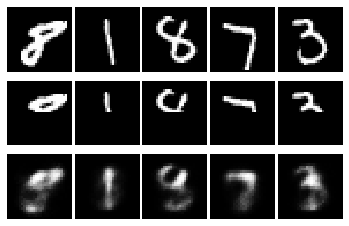

In [102]:
import matplotlib.gridspec as gridspec


def show_images(images, rows):
    rows = rows
    cols = int(images.shape[0]/rows)
    image_width = image_height = np.ceil(np.sqrt(images.shape[1])).astype(int)
    
#     plt.figure(figsize=(5, 5))
    gs = gridspec.GridSpec(rows, cols)
    gs.update(wspace=0.05, hspace=0.05)
    
    for i in range(images.shape[0]):
        axs = plt.subplot(gs[i])
        axs.axis('off')
        axs.set_xticklabels([])
        axs.set_yticklabels([])
        axs.imshow(images[i].reshape([image_width, image_height]))

        
        
test_index = np.random.choice(mnist.validation.images.shape[0], 5)
test_images = mnist.validation.images[test_index]
modified_test_images = np.copy(test_images)
modified_test_images[:, 391:] = 0
output_test_images = rbm.gibbs_sampler(modified_test_images, k=1, sample=False, return_prob=True).numpy()

all_images = np.vstack((test_images, modified_test_images, output_test_images))
show_images(all_images, 3)